# 주제 선정 이유:
에어비앤비 숙소의 가격을 산정하는 과정에서 어떻게 하면 임대 수익을 극대화할 수 있을까 고민을 하던 중, Dynamic Pricing을 위한 알고리즘이 있다는 것을 알게 되었다. 이후 Dynamic Pricing을 제공하는 서비스를 찾았으나 대부분 미국 혹은 유럽의 주요 대도시만 지원이 되고 국내 지원이 되는 서비스가 존재하지 않았다. 그래서 직접 에어비앤비의 숙소 정보를 수집해서 분석하기로 결정했다.

# 가설:
같은 지역에 위치한 숙소들 중 특정 조건이 비슷한 숙소끼리는 숙박료가 비슷할 것이며, 이를 바탕으로 운영 중인 에어 비앤비 숙소의 '적정 가격'을 산출할 수 있을 것이다.

# 데이터 획득:
크롤러를 사용하여 에어 비앤비에 지역, 체크인/체크아웃 날짜를 주고 엑셀 데이터로 저장했다.

# 데이터 가공:
데이터를 트레이닝 셋과 테스트 셋으로 나눈 뒤 모델을 학습시켰다.

# 분석 결과:
특징이 비슷한 숙소끼리는 가격이 비슷하게 수렴하는 현상이 발생했으나 상대적으로 고가의 숙소 혹은 방이 많은 숙소 등의 가격을 예측하는데는 실패했다.

이는 이런 숙소들이 예외적인 요소이기 때문이며, 충분하게 데이터를 많이 수집한다면 오차 범위를 줄일 수 있을 것이다.

# 결론:
지역의 일반적인 숙소 (침실1, 침대1, 수용인원 4인 내외)의 경우 비교 대상이 많으므로 오차가 가장 적은 결과를 얻을 수 있었다.

다만 유명한 숙소(고급 호텔 등)이나 대형 숙소(수용인원 8인 이상 혹은 침실 4개 이상)의 경우에는 가격 오차가 크게 발생했다.

이는 숙소의 브랜드 가치 혹은 썸네일 등의 평가를 반영하기 어렵기 때문이다.

그리고 또 한 가지 고려해봐야할 점은 계절성(Seasonality)이다.

같은 숙소라 하더라도 일 년 중 특정 이벤트가 몰려있는 시기에 가격이 훨씬 불규칙적으로 움직인다.

다른 개선점으로는 '텍스트 데이터'의 카테고라화(Categorization) 이다.

숙소 안내 문구, 후기, 호텔 물품(Ammenities) 등에 대한 자연어 분석을 통해서 숙소 비교에 새로운 기능으로 추가할 수 있다.

# The K-nearest neighbors algorithm
가장 먼저 비교를 위해 내 숙소와 유사한 숙소들을 선택합니다.



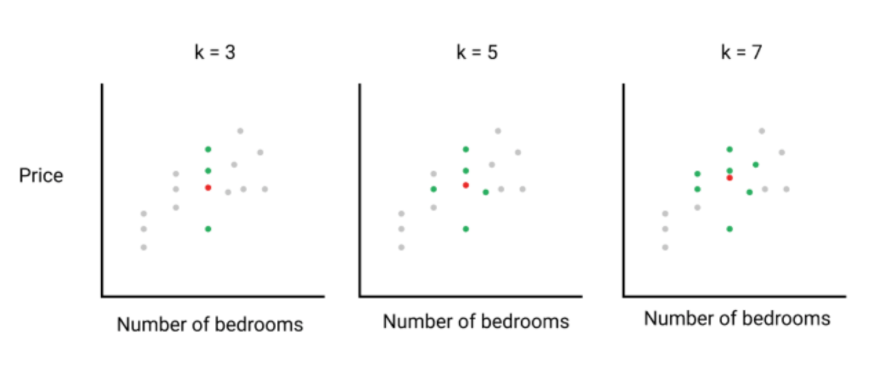

In [1]:
from IPython.display import Image  # 주피터 노트북에 이미지 삽입
Image("C://Users/MyCom/jupyter-tutorial/kaggle/Airbnb-price-prediction/data/20211008_082900_1.png")


다음으로 similar metric (주: 두 개의 대상이 얼마나 유사한 가를 거리로 수치화하는 함수)을 이용해 각 숙소가 얼마나 유사한가를 계산합니다.

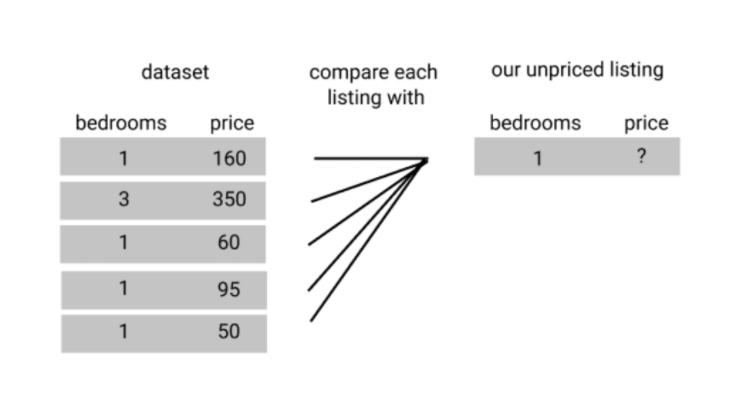

In [2]:
Image("C://Users/MyCom/jupyter-tutorial/kaggle/Airbnb-price-prediction/data/20211008_082900_2.png")


이제 가장 유사도가 높은 k개의 숙소를 골라냅니다.



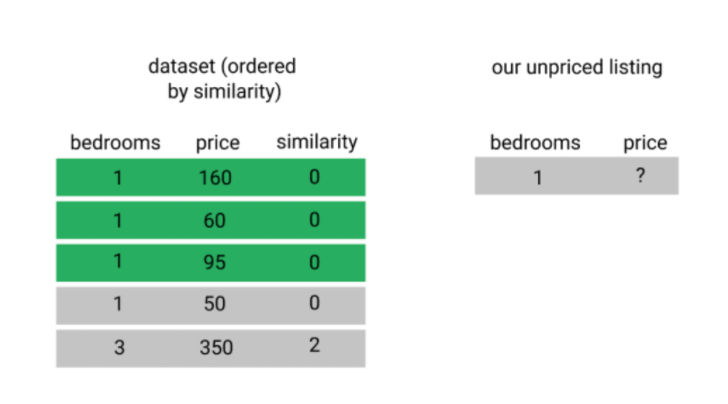

In [3]:
Image("C://Users/MyCom/jupyter-tutorial/kaggle/Airbnb-price-prediction/data/20211008_082900_3.png")



마지막으로 선택된 k개 숙소의 평균 숙박료를 계산해서 이 가격을 우리 숙소의 숙박료로 정합니다.

이제 계산에 어떤 similarity metric을 사용할 것인지 알아본 뒤, k-nearest neighbors을 구현하고, 아직 숙박료를 매기지 않은 숙소의 가격을 예측합니다.

# Euclidean distance
가격과 같은 연속적인 값을 예측할 때 주로 사용하는 similarity metric은 Euclidean distance입니다. 아래는 Euclidean distance를 구하는 공식입니다.



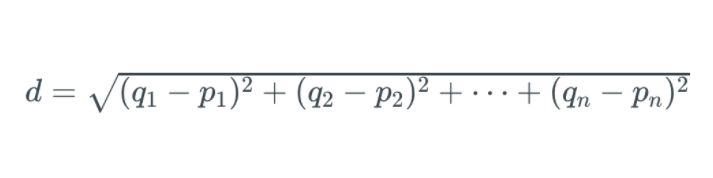

In [4]:
Image("C://Users/MyCom/jupyter-tutorial/kaggle/Airbnb-price-prediction/data/20211008_082900_4.png")


q1에서 qn 그리고 p1에서 pn은 각각 서로 다른 대상의 feature 값을 의미합니다. (침대 수, 침실 수 등)

# Building a simple knn model

만약 하나의 feature만 사용한다면 공식은:

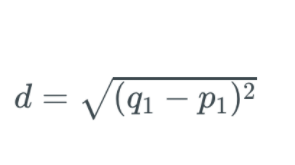

In [5]:
Image("C://Users/MyCom/jupyter-tutorial/kaggle/Airbnb-price-prediction/data/20211008_082900_5.png")


제곱과 제곱근이 서로 상쇄되므로 더 간단하게 나타내면:



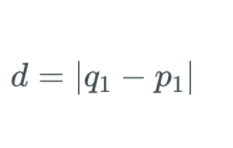

In [6]:
Image("C://Users/MyCom/jupyter-tutorial/kaggle/Airbnb-price-prediction/data/20211008_082900_6.png")



혹은 각 대상들의 feature값 간 차이의 절대값이라고도 말할 수 있습니다.



In [7]:
"""
비슷한 성질을 가진 집단을 분류하는 알고리즘 중 하나인 KNN(K-Nearest-Neighbors)를 사용하여 
특정 지역의 에어비앤비 숙소의 적정 가격을 산정
"""
import pandas as pd
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from datetime import datetime, date
import matplotlib.pyplot as plt
from matplotlib import font_manager

# scale 개념
데이터를 모델링하기 전에는 반드시 스케일링 과정을 거쳐야 한다. 스케일링을 통해 다차원의 값들을 비교 분석하기 쉽게 만들어주며, 자료의 오버플로우(overflow)나 언더플로우(underflow)를 방지 하고, 독립 변수의 공분산 행렬의 조건수(condition number)를 감소시켜 최적화 과정에서의 안정성 및 수렴 속도를 향상 시킨다.

# mean_squared_error 

RMSE란?

( Root Mean Squared Error )

표준편차와 동일하다. 특정 수치에 대한 예측의 정확도를 표현할 때, Accuracy로 판단하기에는 정확도를 올바르게 표기할 수 없어, RMSE 수치로 정확도 판단을 하곤 한다. 일반적으로 해당 수치가 낮을수록 정확도가 높다고 판단한다.

In [8]:
# !pip install xlrd
# !pip install openpyxl

In [9]:
def prepare_data(name):
    listings = pd.read_excel(f'C://Users/MyCom/jupyter-tutorial/kaggle/Airbnb-price-prediction/data/{name}.xlsx',engine='openpyxl')

    features = """
    accomodates bathrooms bedrooms beds nightly_price number_of_reviews id
    """.strip().split(' ')

    listings = listings[features]

    # shuffle listings
    listings = listings.sample(frac=1,random_state=0)

    for col in listings:
        if not (col == 'nightly_price' or col == 'id'):
            listings[col] = scale(listings[col])
    
    return listings


# Evaluating our model
모델의 정확도를 분석하기 위한 간단한 방법은:

데이터 셋을 두 개로 분리:
- 트레이닝셋: 전체 로우의 75%
- 테스트셋: 전체 로우의 25%
테스트셋에 속한 숙소의 값을 예측하기 위해서 트레이닝셋에 있는 데이터로 모델을 훈련시킨다.
예측된 값과 실제 숙박료를 차이를 분석한다.
이제 전체 로우를 train_df 와 test_df로 나눠줍니다.



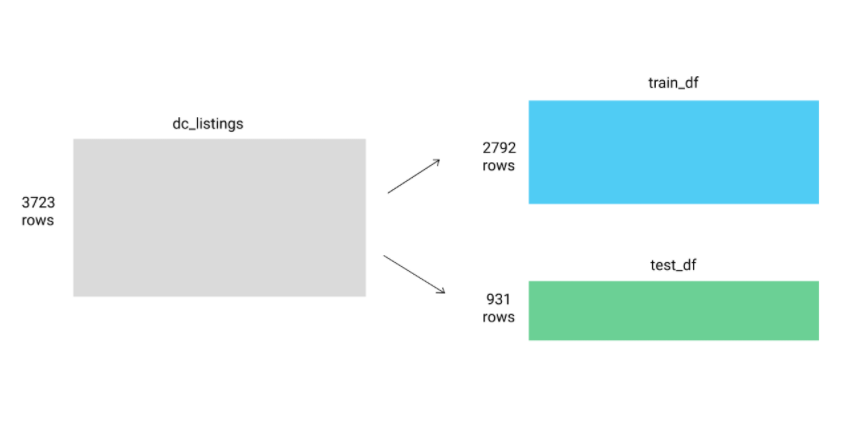

In [10]:
Image("C://Users/MyCom/jupyter-tutorial/kaggle/Airbnb-price-prediction/data/20211008_125206_1.png")



# Using RMSE to evaluate our model

예측을 정교화하기 위해서는 예측값과 측정값의 차이가 클수록 페널티를 줄 필요가 있습니다.

이를 위해 root mean squared error (RMSE)라고 하는 에러값(주: 예측값과 측정값의 차이)의 평균의 제곱근을 사용할 수 있습니다.

아래는 RMSE를 구하는 공식입니다.

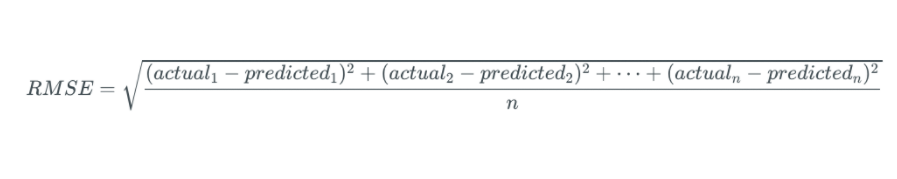

In [16]:
Image("C://Users/MyCom/jupyter-tutorial/kaggle/Airbnb-price-prediction/data/20211008_125618_2.png")



n은 테스트셋의 전체 로우 개수를 의미합니다.

에러값(예측값과 측정값의 차이)를 구한다
에러값을 제곱한다
이렇게 구해진 에러값들을 전부 더한다음 평균낸다
이 평균값의 제곱근을 구한다
의 순서로 이루어진 간단한 계산입니다.

# Introduction to scikit-learn

Scikit-learn은 파이썬으로 구현된 머신러닝 라이브러리 중 가장 유명한 라이브러리입니다. 또한Scikit-learn은 주요 머신러닝 알고리즘을 포함하고 있습니다. 그러므로 데이터 사이언스를 하는 사람이라면 이 라이브러리를 활용할 때 좀 더 빠르게 모델을 구현하고 실험해볼 수 있습니다.

Scikit-learn을 활용하는 workflow는 아래와 같습니다.

- 사용하고 싶은 머신러닝 알고리즘을 고른다

- 트레이닝셋을 활용해서 모델을 학습시킨다

- 모델을 사용해 예측을 한다

- 예측값의 정확도를 평가한다

scikit-learn의 각 모델은 각각 클래스의 형태로 구현되어 있습니다. 그러므로 가장 먼저 할 일은 어떤 클래스를 사용할 것인지를 파악하는 일입니다. 여기서는 KNeighborsRegressor 클래스를 사용하도록 하겠습니다.

숙박료와 같은 숫자값을 예측하는데 사용되는 모델을 regression model이라고 합니다. 머신러닝의 또 다른 분야 중 하나는 classification(분류)이며, 이 경우에는 여러 성격을 가진 서로 다른 집단에서 한 집단이 어떤 집단에 가까운 지를 추측합니다. regressor라는 단어에서 알 수 있듯이 KNeighborsRegressor 클래스는 regression model에 속합니다.

______________________________________________________________________

- n_neighbors: k의 크기, 기본값은 5

- algorithm: 유사도 분석 알고리즘, 기본값은 auto

- p: 거리값 계산 방식, 기본값은 Euclidean distance

In [17]:
def predict(data):
    size_test = int(len(data) * 0.25)
    
    train_df = data.copy().iloc[:size_test]
    test_df = data.copy().iloc[size_test:]

# algorithm : 가장 가까운 이웃을 계산하는데 사용하는 알고리즘
#'ball_tree'는 BallTree를 사용 BallTree
#'kd_tree'는 KDTree를 사용 KDTree
#'brute'는 무차별 대입 검색을 사용합니다.
    knn = KNeighborsRegressor(algorithm='brute', n_neighbors=5)
#accommodates: 수용 가능 인원 / bathrooms: 욕실 개수/ bedrooms: 침실 개수/ beds: 침대 개수
    cols = ['accomodates', 'bathrooms', 'bedrooms', 'beds']

    knn.fit(train_df[cols], train_df['nightly_price'])
    predictions = knn.predict(test_df[cols])
    mse = mean_squared_error(test_df['nightly_price'], predictions)
    rmse = mse ** (1/2)
    
    test_df['expected'] = [round(x / 1000) * 1000 for x in predictions]
    test_df['diff'] = test_df['expected'] - test_df['nightly_price']
    
    return test_df

In [12]:
def draw_graph(result, how_many):
    CHART_SIZE_X = 20
    CHART_SIZE_Y = 20
    
    plt.figure(figsize=(CHART_SIZE_X, CHART_SIZE_Y))
    
    displayed = result[:how_many]
    range_displayed = range(len(result[:how_many]))
    
    font_fname = 'C://Users/MyCom/jupyter-tutorial/kaggle/Airbnb-price-prediction/data/NanumGothic.ttf'
    font_family = font_manager.FontProperties(fname=font_fname).get_name()
    
    plt.rcParams['font.family'] = font_family
    
    plt.bar(range_displayed, displayed['expected'])
    plt.bar(range_displayed, displayed['nightly_price'])
    plt.xticks(range_displayed, displayed['id'])

    for i, v in enumerate(list(displayed['expected'])):
        expected = list(displayed['expected'])[i]
        actual = list(displayed['nightly_price'])[i]
        diff = int(abs(expected - actual)) #절대값함수 사용
        
        position = max(expected, actual) * 1.01
        
        plt.text(i, position, str(f'차이: {diff}'), color='black', fontweight='bold', horizontalalignment='center')
    
    plt.ylabel('Price')
    plt.xlabel('숙소')
    plt.title('Airbnb Price Comparison')
    plt.legend(['expected', 'actual'])
    plt.autoscale(enable=True, axis='x', tight=True)    

춘천, 포항, 홍대, 수원, 강남 5 지역의 데이터가 있습니다. 어떤 지역을 고르시겠습니까?강남
얼마나 많은 숙소의 가격 정보를 비교하시겠습니까?15


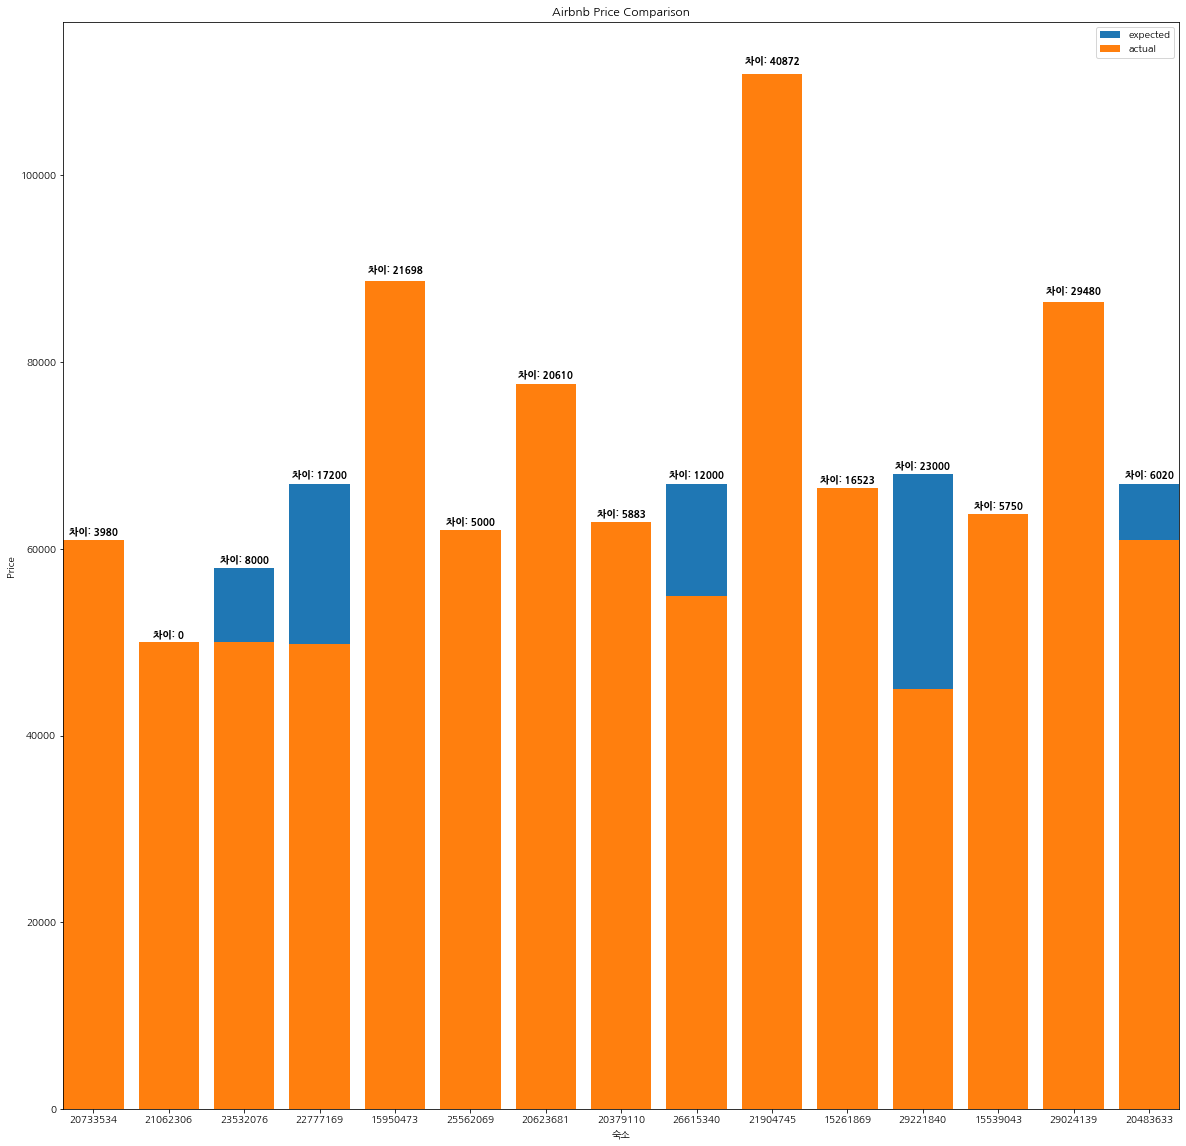

In [13]:
def main():  
    while True:
        listing_files = {
            '춘천': '춘천2021-10-08', 
            '포항': '포항2021-10-08',
            '홍대': '홍대2021-10-08',
            '수원': '수원2021-10-08',
            '강남': '강남2021-10-08',
        }
            
        city = input(f'{", ".join(listing_files.keys())} {len(listing_files.keys())} 지역의 데이터가 있습니다. 어떤 지역을 고르시겠습니까?')
        how_many = 10
        
        try:
            how_many = int(input('얼마나 많은 숙소의 가격 정보를 비교하시겠습니까?'))
        except ValueError:
            print('잘못된 숫자입니다. 기본값인 10개를 보여줍니다.')

        if city in listing_files.keys():
            listings = prepare_data(listing_files[city]) 
            result = predict(listings) 
            draw_graph(result, how_many)
            break

main()